Title: Figure 2, panels b-e

Author: Ruth Hanna

Email: rhanna@broadinstitute.org

Date: 2019-07-08

This file provides the code used to generate Figure 2, panels b-e, which contain the comparison between three webtools for guide design (CHOPCHOP, E-CRISP, and the GPP sgRNA designer). We performed this comparison for 6 protein-coding genes that were all approximately 1200 amino acids. We chose genes of a similar length to avoid very short genes, for which the number of available PAM sites might be limiting.


In [382]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib_venn import venn2, venn3
import matplotlib as mpl

mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Load data

E-CRISP was run with on the "medium" setting, with the following parameters:
* Set "5' base requirement" to "any"
* Set "Exclude poly-T sequences" to True
* Set "Maximum number of results per exon" to 10000 (to disregard spacing requirements for this analysis)

Otherwise, we used the default parameters obtained with the medium setting when "reset form" is clicked. 

Note that by default, the following settings are set to True:
* Exclude hits outside the gene
* Exclude designs in overlapping genes
* Exclude non-exon hits
* Exclude hits outside of coding sequences
* Exclude hits in CpG islands

In [383]:
ecrisp = pd.read_csv('/Users/rhanna/software-tools/20190702_ECRISP.txt',sep='\t')
# Set 'pick' to 1 for all guides because they were included in the output file
ecrisp['pick'] = 1
ecrisp['gene'] = ecrisp['Name'].apply(lambda x: x.split('_')[0])
ecrisp = ecrisp.rename(columns = {'Nucleotide sequence':'sequence'})[['gene','sequence','pick']]
# Drop duplicates rows (E-CRISP lists some guides multiple times in the output file)
ecrisp.drop_duplicates(subset=['sequence'])
# Drop PAMs so that we can join on sgRNA sequence
ecrisp.loc[:,'sequence'] = ecrisp.loc[:,'sequence'].apply(lambda x: x.split(' ')[0])
ecrisp.head()

,gene,sequence,pick
0,ARAP1,GATCCTGGATCGCCGGAACG,1
1,ARAP1,GAACGTGGGCATCAGGGAGA,1
2,ARAP1,GCATCAGGGAGAAGGACTAT,1
3,ARAP1,ATCCTGGATCGCCGGAACGT,1
4,ARAP1,TCTCCCTGATGCCCACGTTC,1


CHOPCHOP does not have a web-based batch mode, so we ran each of the 6 genes individually. All settings were kept as the default.

In [384]:
ARAP1 = pd.read_csv('/Users/rhanna/software-tools/20190625_CHOPCHOP_ARAP1.tsv',sep='\t')
ERBB2 = pd.read_csv('/Users/rhanna/software-tools/20190625_CHOPCHOP_ERBB2.tsv',sep='\t')
JARID2 = pd.read_csv('/Users/rhanna/software-tools/20190625_CHOPCHOP_JARID2.tsv',sep='\t')
NCAPG2 = pd.read_csv('/Users/rhanna/software-tools/20190625_CHOPCHOP_NCAPG2.tsv',sep='\t')
TEX2 = pd.read_csv('/Users/rhanna/software-tools/20190625_CHOPCHOP_TEX2.tsv',sep='\t')
TRPM4 = pd.read_csv('/Users/rhanna/software-tools/20190625_CHOPCHOP_TRPM4.tsv',sep='\t')

for df,gene in [(ARAP1,'ARAP1'),(ERBB2,'ERBB2'),(JARID2,'JARID2'),(NCAPG2,'NCAPG2'),(TEX2,'TEX2'),(TRPM4,'TRPM4')]:
    df['gene'] = gene

# Merge all files together
chopchop = pd.concat([ARAP1,ERBB2])
chopchop = pd.concat([chopchop,JARID2])
chopchop = pd.concat([chopchop,NCAPG2])
chopchop = pd.concat([chopchop,TEX2])
chopchop = pd.concat([chopchop,TRPM4])
chopchop['pick'] = 1
chopchop.to_csv('/Users/rhanna/software-tools/chopchop.csv',index=False)
chopchop = chopchop.rename(columns = {'Target sequence':'sequence'})[['gene','sequence','pick']]

# Drop PAMs from sgRNA sequence so we can join on sequence
chopchop.loc[:,'sequence'] = chopchop.loc[:,'sequence'].apply(lambda x: x[:-3])
chopchop = chopchop.reset_index()
chopchop.head()

,index,gene,sequence,pick
0,0,ARAP1,TCGCCGGAACGTGGGCATCA,1
1,1,ARAP1,ATCCTGGATCGCCGGAACGT,1
2,2,ARAP1,ACACAGCGGTACACGATCAC,1
3,3,ARAP1,GCGCTTAGAGTAAGCGTCCT,1
4,4,ARAP1,TCTGCGCAACGTCTGAGCAC,1


Finally, we load the picks obtained from the GPP sgRNA design web portal. By default, GPP's tool includes a spacing requirement. We chose to ignore this spacing requirement for the purposes of this analysis.

Therefore, we define a "get_picks" function to select all guides that are picks or are only excluded from consideration due to the spacing requirement.

In [385]:
def get_picks(df):
    df.loc[:,'pick'] = np.nan
    for index,row in df.iterrows():
        pick = 0
        if type(df.at[index,'Picking Notes']) == float:
            pick = 1
        elif 'Outside Target Window' not in df.at[index,'Picking Notes']:
            if 'Incompatibility' not in df.at[index,'Picking Notes']:
                if 'Off-target' not in df.at[index,'Picking Notes']:
                    if 'On-Target' not in df.at[index,'Picking Notes']:
                        pick = 1

        df.at[index,'pick'] = pick
    return df

gpp = pd.read_csv('/Users/rhanna/software-tools/20190625_GPP.txt',sep='\t')
gpp = get_picks(gpp)
gpp = gpp.rename(columns = {'Input':'gene','sgRNA Sequence':'sequence'})[['gene','sequence','pick','Picking Notes','Exon Number']]
gpp.head()

,gene,sequence,pick,Picking Notes,Exon Number
0,ERBB2,AACTACCTTTCTACGGACGT,1.0,NaN,8
1,ERBB2,CTTGACCAGCACGTTCCGAG,0.0,Outside Target Window: 5-65%,21
2,ERBB2,AGACCGTTGGACTCACGAGT,1.0,NaN,15
3,ERBB2,CCCTCTACAGCGGTACAGTG,0.0,Outside Target Window: 5-65%,26
4,ERBB2,CAGAACCTGCAAGTAATCCG,1.0,NaN,11


For each gene, we rank the guides within the gene (note that this is already provided by CHOPCHOP). For GPP and E-CRISP, we simply use the order of the output file, as this corresponds to the rank.

We exclude any guides for which the 'pick' column does not equal 1, because these correspond to guides that are delibarately excluded by GPP's tool (e.g. guides containing a TTTT motif).

In [386]:
def rank_within_gene(df):
    df['rank'] = np.nan
    df['percentile'] = np.nan
    rank = 0
    for index,row in df.iterrows():
        gene_count = len(df[(df['gene'] == row['gene']) & (df['pick'] == 1)])
        if index != 0:
            # Check if this is the first guide for a new gene
            # If so, set rank to 0
            if df.at[index,'gene'] != df.at[index-1,'gene']:
                rank = 0
        if df.at[index,'pick'] == 1:
            rank +=1
            df.at[index,'rank'] = rank
            df.at[index,'percentile'] = (float(rank)/float(gene_count))*100
    return df

ecrisp = rank_within_gene(ecrisp)
gpp = rank_within_gene(gpp)
chopchop = rank_within_gene(chopchop)

Finally, we merge all files together, joining on the "sequence" and "gene" columns.

We additionally create a "percentile_bin" column for each tool to bin all guides based on their percentile rank in the tool.

In [387]:
ecrisp = ecrisp.rename(columns = {'pick':'pick_ecrisp','percentile':'percentile_ecrisp','rank':'rank_ecrisp'})
# Use an outer merge to preserve guides that are only picked by one tool
merged = pd.merge(gpp,chopchop,on=['sequence','gene'],how='outer',suffixes=['_gpp','_chopchop'])
merged = pd.merge(merged,ecrisp,on=['sequence','gene'],how='outer')
merged.head()

,gene,sequence,pick_gpp,Picking Notes,Exon Number,rank_gpp,percentile_gpp,index,pick_chopchop,rank_chopchop,percentile_chopchop,pick_ecrisp,rank_ecrisp,percentile_ecrisp
0,ERBB2,AACTACCTTTCTACGGACGT,1.0,NaN,8.0,1.0,0.234742,0.0,1.0,1.0,0.232558,1.0,122.0,13.816535
1,ERBB2,CTTGACCAGCACGTTCCGAG,0.0,Outside Target Window: 5-65%,21.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,593.0,67.157418
2,ERBB2,AGACCGTTGGACTCACGAGT,1.0,NaN,15.0,2.0,0.469484,30.0,1.0,31.0,7.209302,1.0,40.0,4.530011
3,ERBB2,CCCTCTACAGCGGTACAGTG,0.0,Outside Target Window: 5-65%,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ERBB2,CAGAACCTGCAAGTAATCCG,1.0,NaN,11.0,3.0,0.704225,19.0,1.0,20.0,4.651163,1.0,393.0,44.507361


In [388]:
def get_percentile_bin(percentile):
    if math.isnan(percentile):
        return 'not_found'
    elif (0 <= percentile) and (percentile <= 20):
        return '0-20'
    elif (20 < percentile) and (percentile <= 40):
        return '20-40'
    elif (40 < percentile) and (percentile <= 60):
        return '40-60'
    elif (60 < percentile) and (percentile <= 80):
        return '60-80'
    elif (80 < percentile) and (percentile <= 100):
        return '80-100'
    
merged['percentile_bin_gpp'] = merged['percentile_gpp'].apply(get_percentile_bin)
merged['percentile_bin_chopchop'] = merged['percentile_chopchop'].apply(get_percentile_bin)
merged['percentile_bin_ecrisp'] = merged['percentile_ecrisp'].apply(get_percentile_bin)
merged.head()

,gene,sequence,pick_gpp,Picking Notes,Exon Number,rank_gpp,percentile_gpp,index,pick_chopchop,rank_chopchop,percentile_chopchop,pick_ecrisp,rank_ecrisp,percentile_ecrisp,percentile_bin_gpp,percentile_bin_chopchop,percentile_bin_ecrisp
0,ERBB2,AACTACCTTTCTACGGACGT,1.0,NaN,8.0,1.0,0.234742,0.0,1.0,1.0,0.232558,1.0,122.0,13.816535,0-20,0-20,0-20
1,ERBB2,CTTGACCAGCACGTTCCGAG,0.0,Outside Target Window: 5-65%,21.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,593.0,67.157418,not_found,not_found,60-80
2,ERBB2,AGACCGTTGGACTCACGAGT,1.0,NaN,15.0,2.0,0.469484,30.0,1.0,31.0,7.209302,1.0,40.0,4.530011,0-20,0-20,0-20
3,ERBB2,CCCTCTACAGCGGTACAGTG,0.0,Outside Target Window: 5-65%,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_found,not_found,not_found
4,ERBB2,CAGAACCTGCAAGTAATCCG,1.0,NaN,11.0,3.0,0.704225,19.0,1.0,20.0,4.651163,1.0,393.0,44.507361,0-20,0-20,40-60


We create a 3-way Venn diagram showing which guides were selected by which tools.

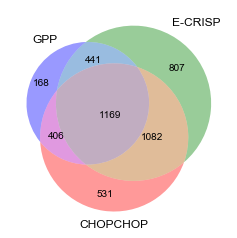

In [389]:
fig,ax=plt.subplots()
venn3(
    subsets=[
    set(gpp[gpp['pick'] == 1]['sequence'].tolist()),
    set(ecrisp['sequence'].tolist()),
    set(chopchop['sequence'].tolist())],
    set_labels=('GPP','E-CRISP','CHOPCHOP'),
    set_colors=('b','g','r'))
fig.savefig('/Users/rhanna/software-tools/venn3.pdf')

# Analyzing "GPP only" guides

CHOPCHOP and E-CRISP do not provide unpicked guides to the user. Therefore, to determine the reason that guides were not picked by those tools but were picked by GPP, we first examine transcripts. I ran CHOPCHOP on all the genes involved with the option checked to include the union of all transcripts. Therefore, if a guide appears in this list, but does not appear in the original list, we know that it was originally excluded due to differences in transcripts.

In [390]:
ARAP1_union = pd.read_csv('/Users/rhanna/software-tools/20190702_ARAP1_CHOPCHOP_tr_union.tsv',sep='\t')
ERBB2_union = pd.read_csv('/Users/rhanna/software-tools/20190702_ERBB2_CHOPCHOP_tr_union.tsv',sep='\t')
JARID2_union = pd.read_csv('/Users/rhanna/software-tools/20190702_JARID2_CHOPCHOP_tr_union.tsv',sep='\t')
NCAPG2_union = pd.read_csv('/Users/rhanna/software-tools/20190702_NCAPG2_CHOPCHOP_tr_union.tsv',sep='\t')
TEX2_union = pd.read_csv('/Users/rhanna/software-tools/20190702_TEX2_CHOPCHOP_tr_union.tsv',sep='\t')
TRPM4_union = pd.read_csv('/Users/rhanna/software-tools/20190702_TRPM4_CHOPCHOP_tr_union.tsv',sep='\t')

for df,gene in [(ARAP1_union,'ARAP1'),(ERBB2_union,'ERBB2'),(JARID2_union,'JARID2'),(NCAPG2_union,'NCAPG2'),(TEX2_union,'TEX2'),(TRPM4_union,'TRPM4')]:
    df['gene'] = gene

chopchop_tr = pd.concat([ARAP1_union,ERBB2_union])
chopchop_tr = pd.concat([chopchop_tr,JARID2_union])
chopchop_tr = pd.concat([chopchop_tr,NCAPG2_union])
chopchop_tr = pd.concat([chopchop_tr,TEX2_union])
chopchop_tr = pd.concat([chopchop_tr,TRPM4_union])
chopchop_tr['pick_chopchop_tr'] = 1
chopchop_tr = chopchop_tr.rename(columns = {'Target sequence':'sequence'})[['gene','sequence','pick_chopchop_tr']]
# Drop PAMs
chopchop_tr.loc[:,'sequence'] = chopchop_tr.loc[:,'sequence'].apply(lambda x: x[:-3])
chopchop_tr = chopchop_tr.reset_index()
chopchop_tr.head()

,index,gene,sequence,pick_chopchop_tr
0,0,ARAP1,TCGCCGGAACGTGGGCATCA,1
1,1,ARAP1,ATCCTGGATCGCCGGAACGT,1
2,2,ARAP1,ACACAGCGGTACACGATCAC,1
3,3,ARAP1,GCGCTTAGAGTAAGCGTCCT,1
4,4,ARAP1,TCTGCGCAACGTCTGAGCAC,1


In [393]:
gpp_only = merged[(merged['pick_gpp'] == 1) & (merged['pick_chopchop'] != 1) & (merged['pick_ecrisp'] != 1)]
print 'number of guides picked only by GPP = %i' % (len(gpp_only))

tr_test = pd.merge(gpp_only,chopchop_tr,on='sequence',how='inner',suffixes=['_gpponly','chopchop_tr'])
print 'number of GPP-only guides that were excluded due to transcript differences = %i' % (len(tr_test))

number of guides picked only by GPP = 168
number of GPP-only guides that were excluded due to transcript differences = 142


# Percentile plots

Finally, we examined guides that were picked by all tools. For each tool, we took the guides ranked in the top 20% in that tool. We then plotted where they fell in the other tools' rankings.

In [362]:
def get_percentile_plots_v2(col1,col2,col3):
    df = merged[(merged['pick_chopchop'] == 1) & 
                (merged['pick_ecrisp'] == 1) & 
                (merged['pick_gpp'] == 1) &
                (merged['percentile_bin_' + col1] == '0-20')]
    
    print len(df)
    lims_list = ['0-20','20-40','40-60','60-80','80-100']
    
    col2_list = []
    for lims in lims_list:
        count = len(df[(df['percentile_bin_' + col2] == lims)])
        col2_list.append(100*float(count)/float(len(df)))
        
    col3_list = []
    for lims in lims_list:
        count = len(df[(df['percentile_bin_' + col3] == lims)])
        col3_list.append(100*float(count)/float(len(df)))
    
    
    color_dict = {
        'gpp':'mediumslateblue',
        'ecrisp':'mediumseagreen',
        'chopchop':'salmon'
    }
    
    fig,ax=plt.subplots(figsize=(5,4))
    width = 0.3
    x = np.arange(5)
    plt.bar(x=x-width/2,height=col2_list,width=width,label=col2,color=color_dict[col2])
    plt.bar(x=x+width/2,height=col3_list,width=width,label=col3,color=color_dict[col3])
    plt.xticks(x,lims_list,fontsize=16)
    ax.set_title('Top 20% of ' + col1.upper() + ' guides',fontsize=16)
    ax.set_ylabel('Percent of guides',fontsize=16)
    ax.set_xlabel('Percentile rank by other tools',fontsize=16)    
    ax.set_ylim(0,45)
    ax.set_yticks([0,10,20,30,40])
    ax.set_yticklabels([0,10,20,30,40],fontsize=14)
    plt.tight_layout()
    fig.savefig('/Users/rhanna/software-tools/' + col1 + '_' + col2 + '_' + col3 + '.pdf')
    
    return data

263


,0-20,20-40,40-60,60-80,80-100
0,41.935484,26.01626,20.689655,13.061224,7.537688


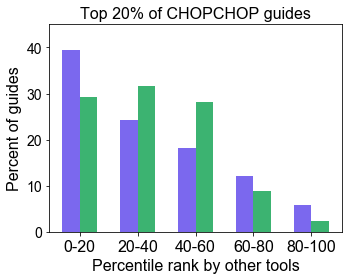

In [363]:
data = get_percentile_plots_v2('chopchop','gpp','ecrisp')
data

314


,0-20,20-40,40-60,60-80,80-100
0,41.935484,26.01626,20.689655,13.061224,7.537688


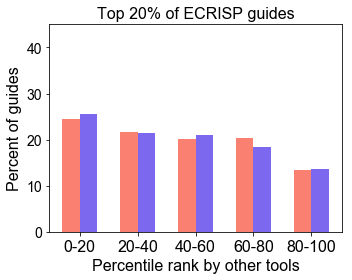

In [364]:
data = get_percentile_plots_v2('ecrisp','chopchop','gpp')
data

248


,0-20,20-40,40-60,60-80,80-100
0,41.935484,26.01626,20.689655,13.061224,7.537688


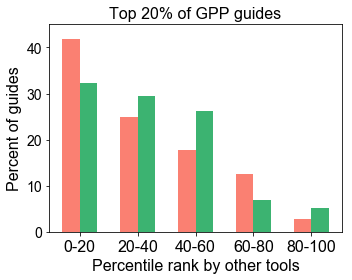

In [365]:
data = get_percentile_plots_v2('gpp','chopchop','ecrisp')
data